# **CVE TO MITRE BERT (WITH CLUSTER)**

# TRAIN

In [ ]:
pip install sentence-transformers

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.cluster import KMeans
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer


# --------- Load Pretrained BERT Model ---------
model_dir = '/content/Untitled Folder'
tokenizer = BertTokenizer.from_pretrained(model_dir)
bert_model = BertModel.from_pretrained(model_dir)

# --------- Load MITRE Techniques Dataset ---------
mitre_df = pd.read_csv('Processed_mitre_recommidtaion.csv')
mitre_texts = mitre_df['Processed_Technique'].tolist()

# --------- Compute Embeddings for MITRE Techniques ---------
def compute_embeddings(texts, model, tokenizer, max_length=128):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', max_length=max_length, truncation=True, padding='max_length').to('cpu')
        with torch.no_grad():
            embedding = model(**inputs).pooler_output
        embeddings.append(embedding.squeeze().cpu().numpy())
    return np.array(embeddings)

# Compute embeddings for MITRE techniques
mitre_embeddings = compute_embeddings(mitre_texts, bert_model, tokenizer)

# --------- KMeans Clustering for MITRE Techniques ---------
num_clusters = 23
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
mitre_clusters = kmeans.fit_predict(mitre_embeddings)

# Save the KMeans model to disk
kmeans_model_path = './kmeans_CVEtoMITRE.pkl'
joblib.dump(kmeans, kmeans_model_path)
print(f"KMeans model saved to {kmeans_model_path}")

# Add MITRE-assigned clusters to the dataset
mitre_df['assigned_cluster_MAP2'] = mitre_clusters

# --------- Load CVE Dataset ---------
lama_df = pd.read_csv('PRE_FRI_TRAIN_CVE_BERTresults.csv')
lama_df['combined_text'] = lama_df['cve_name'] + " " + lama_df['cve_text']

# --------- Preselect MITRE Techniques using TF-IDF ---------
def preselect_mitre(cve_texts, mitre_texts, top_n=5):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_cve = vectorizer.fit_transform(cve_texts)
    tfidf_mitre = vectorizer.transform(mitre_texts)

    preselected_mitre_indices = []
    for i in range(tfidf_cve.shape[0]):
        similarities = cosine_similarity(tfidf_cve[i], tfidf_mitre).flatten()
        top_indices = similarities.argsort()[-top_n:][::-1]
        preselected_mitre_indices.append(top_indices)

    return preselected_mitre_indices

preselected_mitre_indices = preselect_mitre(lama_df['cve_text'].tolist(), mitre_texts, top_n=5)

# --------- Generate Embeddings for CVE Texts ---------
train_embeddings = compute_embeddings(lama_df['cve_text'].tolist(), bert_model, tokenizer)

# --------- Compute Cosine Similarity ---------
similarity_matrix = cosine_similarity(train_embeddings, mitre_embeddings)

# --------- Extract Top Matching Techniques ---------
output_data = {
    'cve_name': [], 'cve_text': [], 'combined_text': [], 'cve_full_text': [],
    'assigned_cluster': [], 'similarity_score': [],
    'Tactic1': [], 'Technique1': [], 'Mitigation1': [],
    'Tactic2': [], 'Technique2': [], 'Mitigation2': [],
    'Tactic3': [], 'Technique3': [], 'Mitigation3': [],
    'mitre_correctly_mapped_cluster': []
}

for i in range(len(lama_df)):
    top_indices = np.argsort(similarity_matrix[i])[-3:][::-1]
    top_scores = similarity_matrix[i, top_indices]

    top_techniques = []
    top_tactics = []
    top_mitigations = []
    for j in range(3):
        top_techniques.append(mitre_df['Technique'].iloc[top_indices[j]])
        top_tactics.append(mitre_df['Tactic'].iloc[top_indices[j]])
        top_mitigations.append(mitre_df['mitigation'].iloc[top_indices[j]])

    output_data['cve_name'].append(lama_df['cve_name'].iloc[i])
    output_data['cve_text'].append(lama_df['cve_text'].iloc[i])
    output_data['combined_text'].append(lama_df['combined_text'].iloc[i])
    output_data['cve_full_text'].append(lama_df['cve_text'].iloc[i])
    output_data['assigned_cluster'].append(kmeans.predict(train_embeddings[i].reshape(1, -1))[0])
    output_data['similarity_score'].append('; '.join(map(str, top_scores)))

    output_data['Tactic1'].append(top_tactics[0] if len(top_tactics) > 0 else '')
    output_data['Technique1'].append(top_techniques[0] if len(top_techniques) > 0 else '')
    output_data['Mitigation1'].append(top_mitigations[0] if len(top_mitigations) > 0 else '')

    output_data['Tactic2'].append(top_tactics[1] if len(top_tactics) > 1 else '')
    output_data['Technique2'].append(top_techniques[1] if len(top_techniques) > 1 else '')
    output_data['Mitigation2'].append(top_mitigations[1] if len(top_mitigations) > 1 else '')

    output_data['Tactic3'].append(top_tactics[2] if len(top_tactics) > 2 else '')
    output_data['Technique3'].append(top_techniques[2] if len(top_techniques) > 2 else '')
    output_data['Mitigation3'].append(top_mitigations[2] if len(top_mitigations) > 2 else '')

    output_data['mitre_correctly_mapped_cluster'].append(
        mitre_df.loc[top_indices[0], 'assigned_cluster_MAP2'] if len(top_indices) > 0 else None
    )

# --------- Save Results ---------
output_df = pd.DataFrame(output_data)
output_file = 'TUE_MAP_CVEtoMITRE.csv'
output_df.to_csv(output_file, index=False)

print(f"Final dataset saved to {output_file}")


KMeans model saved to ./kmeans_CVEtoMITRE.pkl
Final dataset saved to TUE_MAP_CVEtoMITRE.csv


In [ ]:
np.save('cve_embeddings.npy', train_embeddings)  # Save CVE embeddings
np.save('mitre_embeddings.npy', mitre_embeddings)  # Save MITRE embeddings


# TEST

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torch.utils.data import DataLoader, Dataset
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

# --------- Load Pretrained BERT Model ---------
model_dir = '/content/Untitled Folder'
tokenizer = BertTokenizer.from_pretrained(model_dir)
bert_model = BertModel.from_pretrained(model_dir)

# --------- Load MITRE Techniques Dataset ---------
mitre_df = pd.read_csv('Processed_mitre_recommidtaion.csv')
mitre_texts = mitre_df['Processed_Technique'].tolist()

# --------- Compute Embeddings for MITRE Techniques ---------
def compute_embeddings(texts, model, tokenizer, max_length=128):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', max_length=max_length, truncation=True, padding='max_length').to('cpu')
        with torch.no_grad():
            embedding = model(**inputs).pooler_output
        embeddings.append(embedding.squeeze().cpu().numpy())
    return np.array(embeddings)

# Compute embeddings for MITRE techniques
mitre_embeddings = compute_embeddings(mitre_texts, bert_model, tokenizer)

# --------- Load Pretrained KMeans Model ---------
kmeans_model_path = './kmeans_CVEtoMITRE.pkl'
kmeans = joblib.load(kmeans_model_path)
print(f"KMeans model loaded from {kmeans_model_path}")

# Assign clusters to MITRE techniques
mitre_clusters = kmeans.predict(mitre_embeddings)
mitre_df['assigned_cluster_MAP2'] = mitre_clusters

# --------- Load CVE Dataset ---------
lama_df = pd.read_csv('PRE_FRI_TEST_CVE_BERTresults.csv')
lama_df['combined_text'] = lama_df['cve_name'] + " " + lama_df['cve_text']

# --------- Preselect MITRE Techniques using TF-IDF ---------
def preselect_mitre(cve_texts, mitre_texts, top_n=5):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_cve = vectorizer.fit_transform(cve_texts)
    tfidf_mitre = vectorizer.transform(mitre_texts)

    preselected_mitre_indices = []
    for i in range(tfidf_cve.shape[0]):
        similarities = cosine_similarity(tfidf_cve[i], tfidf_mitre).flatten()
        top_indices = similarities.argsort()[-top_n:][::-1]
        preselected_mitre_indices.append(top_indices)

    return preselected_mitre_indices

preselected_mitre_indices = preselect_mitre(lama_df['cve_text'].tolist(), mitre_texts, top_n=5)

# --------- Generate Embeddings for CVE Texts ---------
train_embeddings = compute_embeddings(lama_df['cve_text'].tolist(), bert_model, tokenizer)

# --------- Compute Cosine Similarity ---------
similarity_matrix = cosine_similarity(train_embeddings, mitre_embeddings)

# --------- Extract Top Matching Techniques ---------
output_data = {
    'cve_name': [], 'cve_text': [], 'combined_text': [], 'cve_full_text': [],
    'assigned_cluster': [], 'similarity_score': [],
    'Tactic1': [], 'Technique1': [], 'Mitigation1': [],
    'Tactic2': [], 'Technique2': [], 'Mitigation2': [],
    'Tactic3': [], 'Technique3': [], 'Mitigation3': [],
    'mitre_correctly_mapped_cluster': []
}

for i in range(len(lama_df)):
    top_indices = np.argsort(similarity_matrix[i])[-3:][::-1]
    top_scores = similarity_matrix[i, top_indices]

    top_techniques = []
    top_tactics = []
    top_mitigations = []
    for j in range(3):
        top_techniques.append(mitre_df['Technique'].iloc[top_indices[j]])
        top_tactics.append(mitre_df['Tactic'].iloc[top_indices[j]])
        top_mitigations.append(mitre_df['mitigation'].iloc[top_indices[j]])

    output_data['cve_name'].append(lama_df['cve_name'].iloc[i])
    output_data['cve_text'].append(lama_df['cve_text'].iloc[i])
    output_data['combined_text'].append(lama_df['combined_text'].iloc[i])
    output_data['cve_full_text'].append(lama_df['cve_text'].iloc[i])
    output_data['assigned_cluster'].append(kmeans.predict(train_embeddings[i].reshape(1, -1))[0])
    output_data['similarity_score'].append('; '.join(map(str, top_scores)))

    output_data['Tactic1'].append(top_tactics[0] if len(top_tactics) > 0 else '')
    output_data['Technique1'].append(top_techniques[0] if len(top_techniques) > 0 else '')
    output_data['Mitigation1'].append(top_mitigations[0] if len(top_mitigations) > 0 else '')

    output_data['Tactic2'].append(top_tactics[1] if len(top_tactics) > 1 else '')
    output_data['Technique2'].append(top_techniques[1] if len(top_techniques) > 1 else '')
    output_data['Mitigation2'].append(top_mitigations[1] if len(top_mitigations) > 1 else '')

    output_data['Tactic3'].append(top_tactics[2] if len(top_tactics) > 2 else '')
    output_data['Technique3'].append(top_techniques[2] if len(top_techniques) > 2 else '')
    output_data['Mitigation3'].append(top_mitigations[2] if len(top_mitigations) > 2 else '')

    output_data['mitre_correctly_mapped_cluster'].append(
        mitre_df.loc[top_indices[0], 'assigned_cluster_MAP2'] if len(top_indices) > 0 else None
    )

# --------- Save Results ---------
output_df = pd.DataFrame(output_data)
output_file = 'TUE_MAP_CVEtoMITR_TEST.csv'
output_df.to_csv(output_file, index=False)

print(f"Final dataset saved to {output_file}")



KMeans model loaded from ./kmeans_CVEtoMITRE.pkl
Final dataset saved to TUE_MAP_CVEtoMITR_TEST.csv


# Calculating the matrics

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from xgboost import XGBClassifier

# Load the dataset
file_path = 'TUE_MAP_CVEtoMITR_TEST.csv'
df = pd.read_csv(file_path)

# Ensure the required columns are present
required_columns = ['assigned_cluster', 'mitre_correctly_mapped_cluster']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"Missing required columns: {missing_columns}")

# Extract features and target
X = df['assigned_cluster'].values.reshape(-1, 1)  # Features
y = df['mitre_correctly_mapped_cluster']          # Target labels

# Map classes to sequential integers
unique_classes = sorted(y.unique())
class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}
y_mapped = y.map(class_mapping)

# Calculate class weights for imbalance handling
class_counts = y_mapped.value_counts()
total_samples = len(y_mapped)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
scale_pos_weight = [class_weights[cls] for cls in sorted(class_counts.index)]

# Train XGBoost classifier
xgb_model = XGBClassifier(
    objective='multi:softmax',  # Multi-class classification
    num_class=len(unique_classes),
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

xgb_model.fit(X, y_mapped)

# Predict on the same dataset
y_pred_mapped = xgb_model.predict(X)

# Map predictions back to original class labels
reverse_mapping = {v: k for k, v in class_mapping.items()}
y_pred = pd.Series(y_pred_mapped).map(reverse_mapping)

# Calculate metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')

# Print results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Calculate metrics
accuracy2 = accuracy_score(y, y_pred)
precision2 = precision_score(y, y_pred, average='macro')
recall2 = recall_score(y, y_pred, average='macro')
f12 = f1_score(y, y_pred, average='macro')
# Print results
print(f"Accuracy: {accuracy2:.2f}")
print(f"Precision: {precision2:.2f}")
print(f"Recall: {recall2:.2f}")
print(f"F1 Score: {f12:.2f}")

# Calculate metrics
accuracy3 = accuracy_score(y, y_pred)
precision3 = precision_score(y, y_pred, average='micro')
recall3 = recall_score(y, y_pred, average='micro')
f13 = f1_score(y, y_pred, average='micro')
# Print results
print(f"Accuracy: {accuracy3:.2f}")
print(f"Precision: {precision3:.2f}")
print(f"Recall: {recall3:.2f}")
print(f"F1 Score: {f13:.2f}")


# Optional: Detailed classification report
print("\nClassification Report:")
print(classification_report(y, y_pred))



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.77
Precision: 0.67
Recall: 0.77
F1 Score: 0.70
Accuracy: 0.77
Precision: 0.43
Recall: 0.41
F1 Score: 0.41
Accuracy: 0.77
Precision: 0.77
Recall: 0.77
F1 Score: 0.77

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.63      0.70      0.66        56
           2       0.00      0.00      0.00        30
           3       1.00      0.42      0.60       259
           4       0.00      0.00      0.00        13
           6       0.73      0.96      0.83      2026
           7       0.00      0.00      0.00        73
           8       0.77      0.96      0.85       552
           9       0.98      1.00      0.99       298
          13       0.94      0.69      0.79       180
          17       1.00      1.00      1.00         4
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         2
          20       0.00      0.00      0.0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

# Drawing
* Count of CVEs in Each Cluster
* Density Plot of Similarity Scores by Cluster (Lines Only
* Network Graph of MITRE Clusters with Color Key

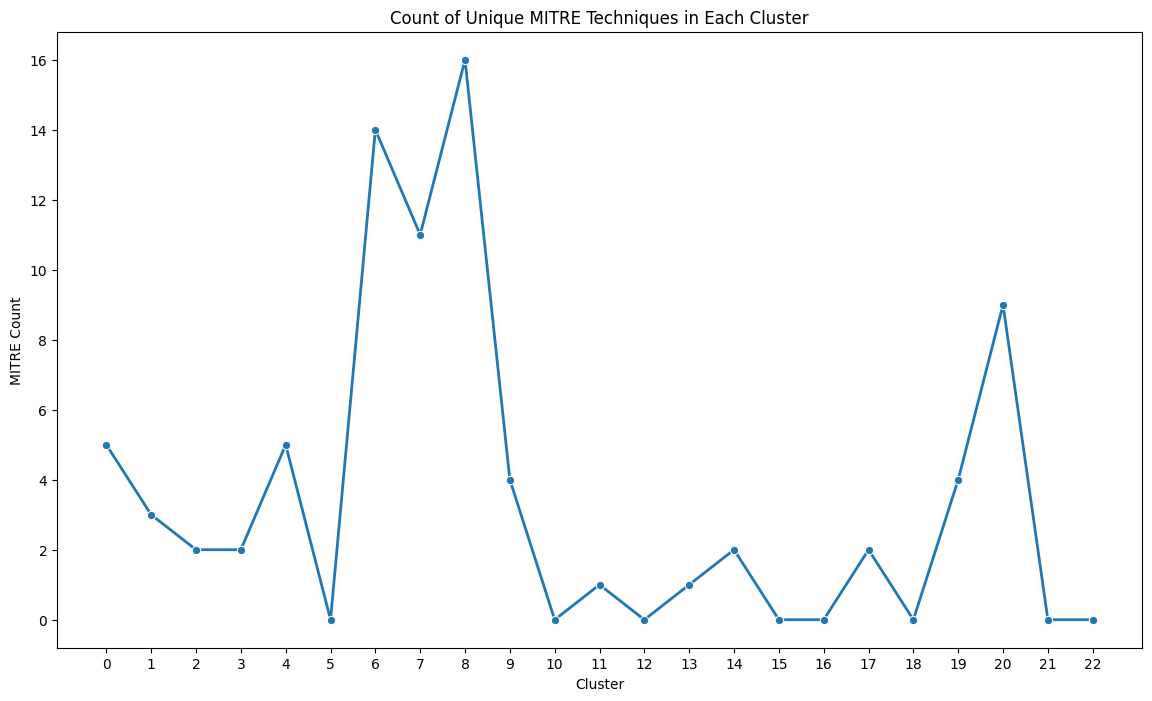

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert output_data to a DataFrame
output_df = pd.DataFrame(output_data)

# Ensure necessary columns are present
required_columns = ['assigned_cluster', 'Technique1']
missing_columns = [col for col in required_columns if col not in output_df.columns]
if missing_columns:
    raise ValueError(f"Missing required columns in output_data: {missing_columns}")

num_clusters = 23
all_clusters = range(num_clusters)

# Count the number of  MITRE techniques ('Technique1') in each cluster
mitre_counts_per_cluster = (
    output_df.groupby('assigned_cluster')['Technique1']
    .nunique()
    .reindex(all_clusters, fill_value=0)
    .sort_index()
)

# Plot: Line plot for count of unique MITRE techniques in each cluster
plt.figure(figsize=(14, 8))
sns.lineplot(
    x=mitre_counts_per_cluster.index,
    y=mitre_counts_per_cluster.values,
    marker="o",
    linewidth=2
)

# Customize the plot
plt.title('Count of Unique MITRE Techniques in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('MITRE Count')
plt.grid(False)  # Remove grid for a cleaner look
plt.xticks(ticks=all_clusters, labels=all_clusters)  # Ensure proper x-axis labels
plt.show()


In [ ]:
import pandas as pd

# File path to the dataset
file_path = 'TUE_MAP_CVEtoMITR_TEST5.csv'  # Replace with your actual file path

# Load the dataset into a DataFrame
output_df = pd.read_csv(file_path)

# Proceed with the analysis or processing
print(output_df.head())  # Display the first few rows for verification


         cve_name                                           cve_text  \
0  CVE-2022-22161  uncontrolled resource consumption vulnerabilit...   
1  CVE-2021-28205  specific function asus bmc firmware web manage...   
2  CVE-2020-14068  issue discovered mk auth web login functionali...   
3  CVE-2020-15170  apollo adminservice version implement access c...   
4  CVE-2018-17877  lottery smart contract implementation greedy e...   

                                       combined_text  \
0  CVE-2022-22161 uncontrolled resource consumpti...   
1  CVE-2021-28205 specific function asus bmc firm...   
2  CVE-2020-14068 issue discovered mk auth web lo...   
3  CVE-2020-15170 apollo adminservice version imp...   
4  CVE-2018-17877 lottery smart contract implemen...   

                                       cve_full_text  assigned_cluster  \
0  uncontrolled resource consumption vulnerabilit...                 9   
1  specific function asus bmc firmware web manage...                 6   
2  issue

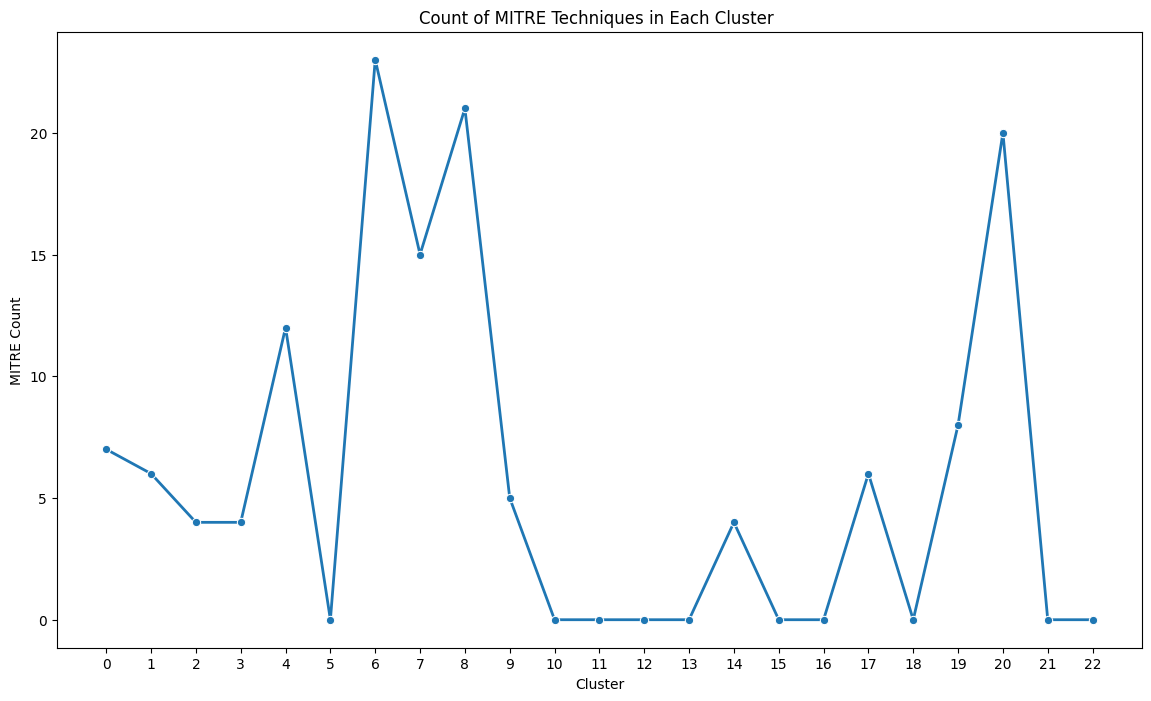

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# File path to the dataset
file_path = 'TUE_MAP_CVEtoMITR_TEST5.csv'  # Replace with your actual file path

# Load the dataset into a DataFrame
output_data = pd.read_csv(file_path)


# Convert output_data to a DataFrame
output_df = pd.DataFrame(output_data)

# Ensure necessary columns are present for all techniques
required_columns = ['assigned_cluster', 'Technique1', 'Technique2', 'Technique3']
missing_columns = [col for col in required_columns if col not in output_df.columns]
if missing_columns:
    raise ValueError(f"Missing required columns in output_data: {missing_columns}")

num_clusters = 23
all_clusters = range(num_clusters)

# Combine all technique columns into one for counting
output_df['all_techniques'] = (
    output_df['Technique1'].astype(str) + ',' +
    output_df['Technique2'].astype(str) + ',' +
    output_df['Technique3'].astype(str)
)

# Split combined techniques into a list and explode for counting
technique_exploded_df = output_df.assign(
    all_techniques=output_df['all_techniques'].str.split(',')
).explode('all_techniques')

# Remove NaN or empty techniques (if any)
technique_exploded_df = technique_exploded_df[technique_exploded_df['all_techniques'].notna()]
technique_exploded_df['all_techniques'] = technique_exploded_df['all_techniques'].str.strip()

# Count the number of unique MITRE techniques across all columns for each cluster
mitre_counts_per_cluster = (
    technique_exploded_df.groupby('assigned_cluster')['all_techniques']
    .nunique()
    .reindex(all_clusters, fill_value=0)
    .sort_index()
)

# Plot: Line plot for count of unique MITRE techniques in each cluster
plt.figure(figsize=(14, 8))
sns.lineplot(
    x=mitre_counts_per_cluster.index,
    y=mitre_counts_per_cluster.values,
    marker="o",
    linewidth=2
)

# Customize the plot
plt.title('Count of MITRE Techniques in Each Cluster ')
plt.xlabel('Cluster')
plt.ylabel('MITRE Count')
plt.grid(False)
plt.xticks(ticks=all_clusters, labels=all_clusters)
plt.show()


<ipython-input-10-568a19db3368>:22: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
<ipython-input-10-568a19db3368>:22: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


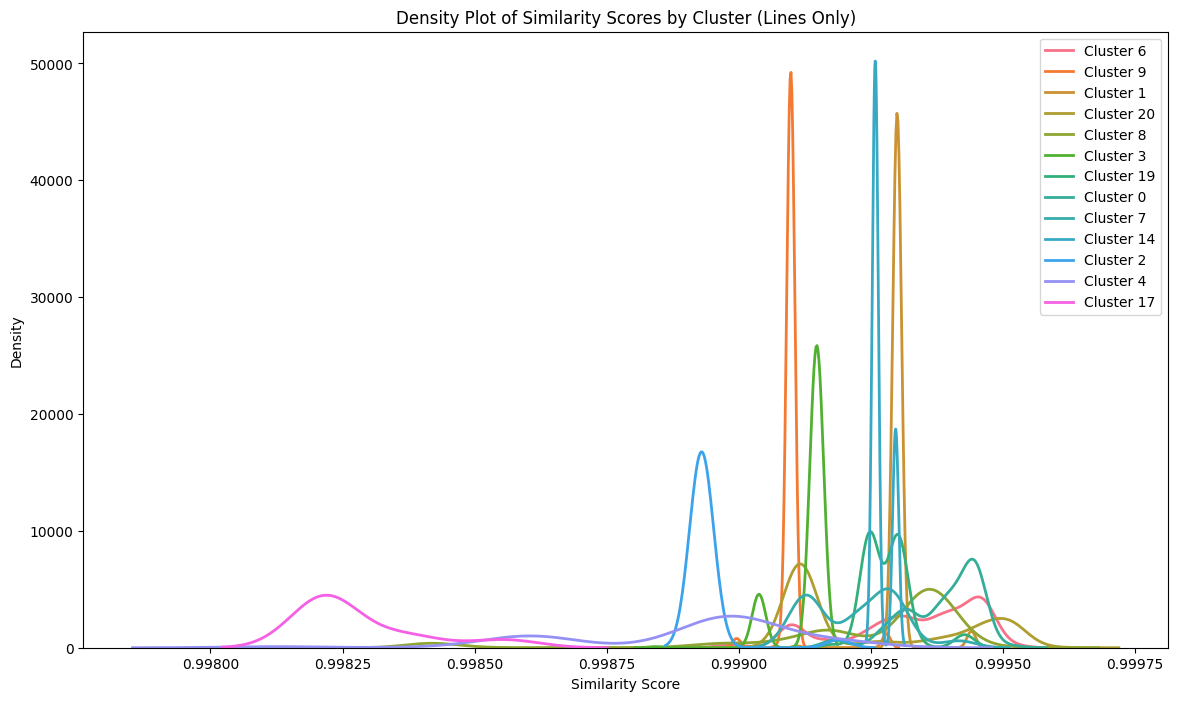

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert output_data to a DataFrame
output_df = pd.DataFrame(output_data)

output_df['similarity_score'] = output_df['similarity_score'].apply(
    lambda x: max(map(float, x.split(';'))) if isinstance(x, str) else x
)


palette = sns.color_palette("husl", len(output_df['assigned_cluster'].unique()))


plt.figure(figsize=(14, 8))
for i, cluster in enumerate(output_df['assigned_cluster'].unique()):
    cluster_data = output_df[output_df['assigned_cluster'] == cluster]['similarity_score']
    if not cluster_data.empty:
        sns.kdeplot(
            cluster_data,
            label=f'Cluster {cluster}',
            color=palette[i],
            linewidth=2
        )

plt.title('Density Plot of Similarity Scores by Cluster (Lines Only)')
plt.xlabel('Similarity Score')
plt.ylabel('Density')
plt.legend()
plt.grid(False)
plt.show()


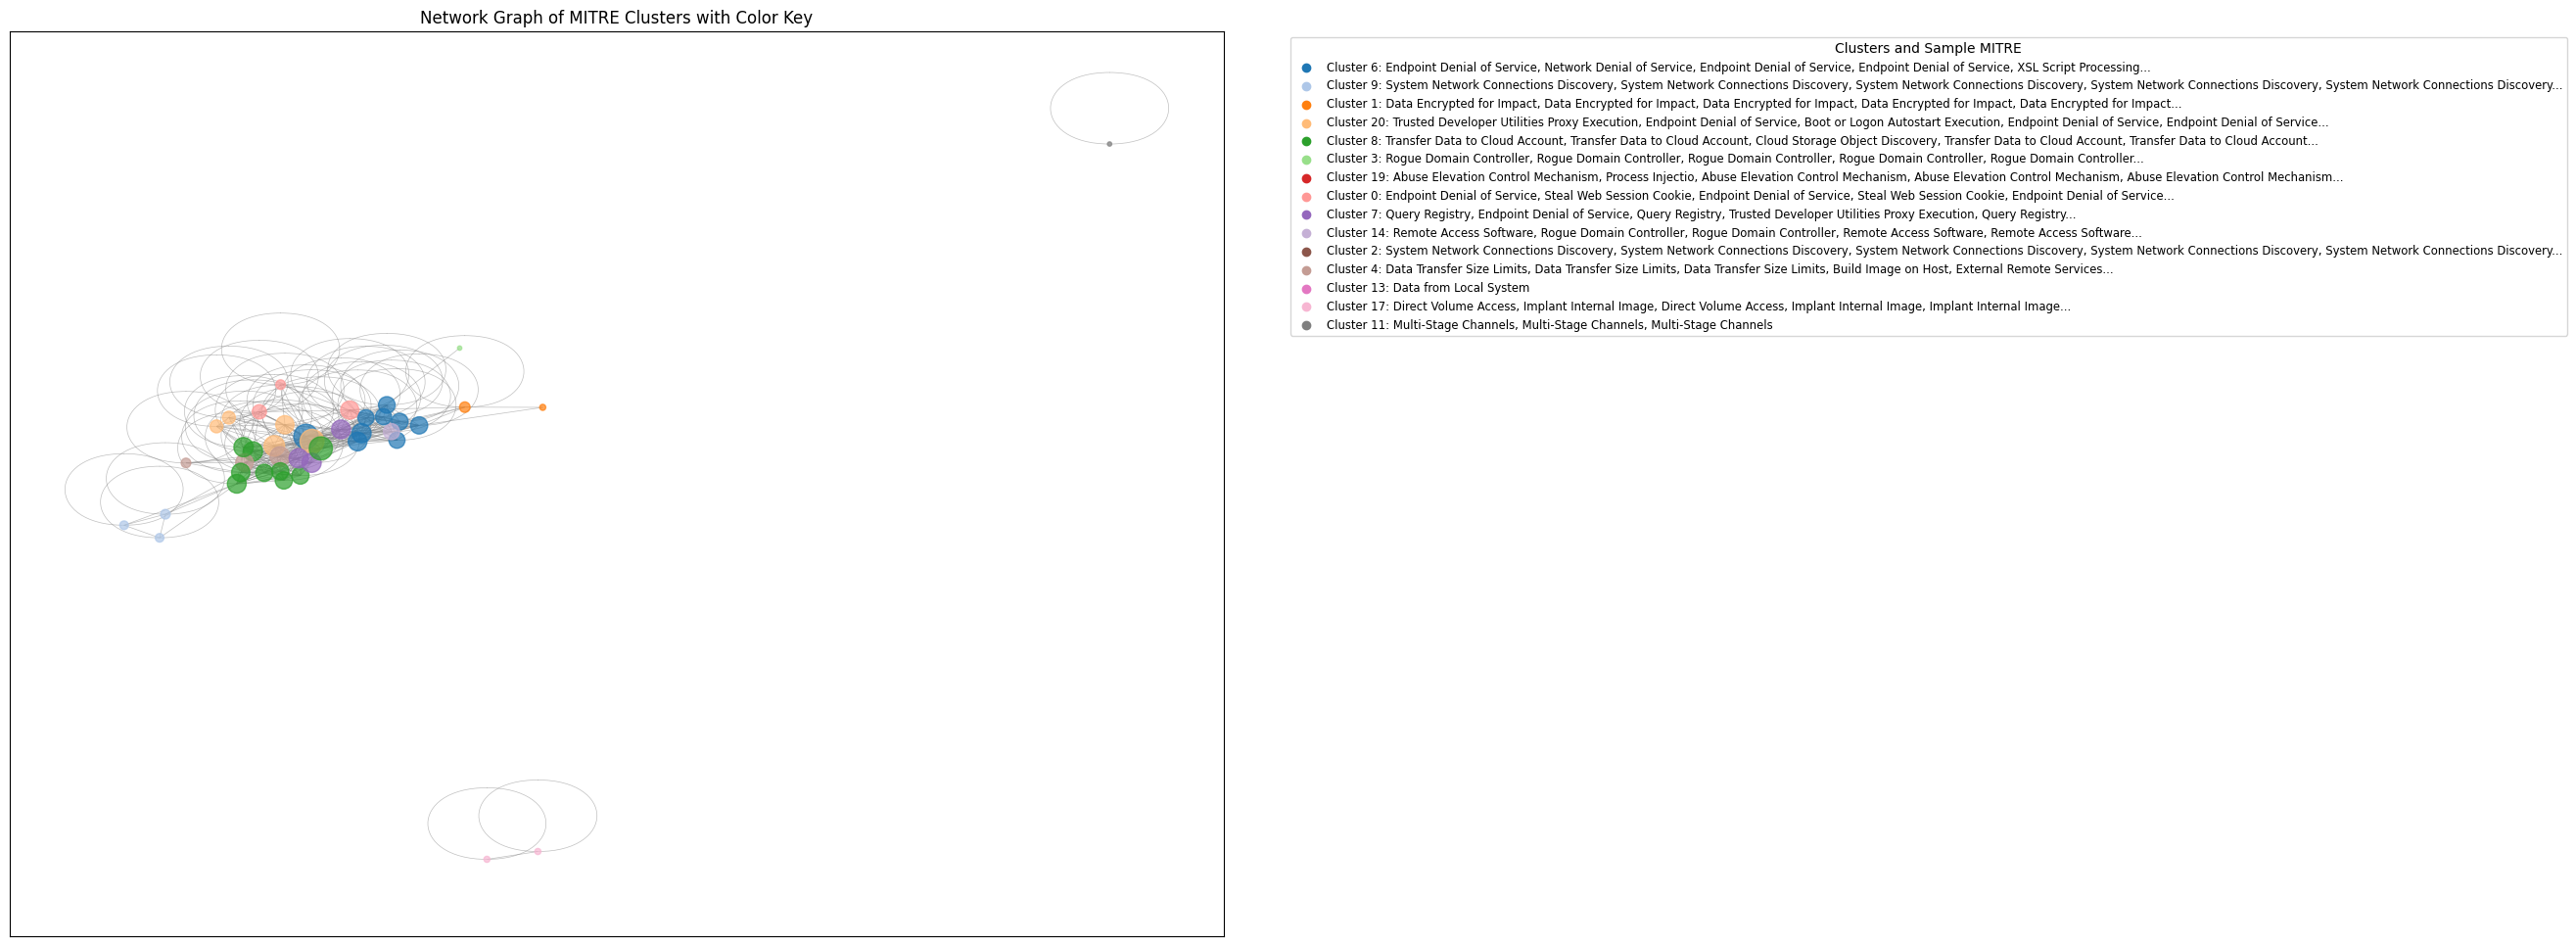

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Convert output_data to a DataFrame
output_df = pd.DataFrame(output_data)

# Ensure necessary columns exist and are clean
if 'assigned_cluster' not in output_df.columns or 'Technique1' not in output_df.columns:
    raise ValueError("The required columns 'assigned_cluster' and 'cve_name' are missing in the dataset.")

# Create a graph
G = nx.Graph()

# Add nodes with the CVE names and their cluster as an attribute
for _, row in output_df.iterrows():
    G.add_node(row['Technique1'], cluster=row['assigned_cluster'])

# Add edges between nodes in the same cluster to show their connection
for cluster in output_df['assigned_cluster'].unique():
    cluster_data = output_df[output_df['assigned_cluster'] == cluster]
    cluster_cves = cluster_data['Technique1'].tolist()

    # Connect each node to every other node in the cluster
    for i in range(len(cluster_cves)):
        for j in range(i + 1, len(cluster_cves)):
            G.add_edge(cluster_cves[i], cluster_cves[j])

# Set up colors and sizes for nodes based on clusters
pos = nx.spring_layout(G)
plt.figure(figsize=(16, 12))

# Assign colors for each cluster
clusters = output_df['assigned_cluster'].unique()
colors = plt.cm.tab20(range(len(clusters)))
color_map = {cluster: colors[i] for i, cluster in enumerate(clusters)}

# Node colors and sizes
node_colors = [color_map[G.nodes[node]['cluster']] for node in G.nodes]
node_sizes = [len(list(G.neighbors(node))) * 10 for node in G.nodes]
# Draw the network
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.7)
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5, width=0.5)

# Create a dictionary to map clusters to MITRE for the legend
cluster_cve_map = {}
for cluster in clusters:
    cve_names = output_df[output_df['assigned_cluster'] == cluster]['Technique1'].tolist()
    cluster_cve_map[cluster] = cve_names

# Display the legend with CVE names for each cluster
legend_labels = []
for cluster, cves in cluster_cve_map.items():
    label = f"Cluster {cluster}: " + ", ".join(cves[:5]) + ("..." if len(cves) > 5 else "")
    legend_labels.append((label, color_map[cluster]))

# Create a custom legend
for label, color in legend_labels:
    plt.scatter([], [], color=color, label=label)

plt.legend(title='Clusters and Sample MITRE', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.title('Network Graph of MITRE Clusters with Color Key')
plt.show()
